In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of FeatureRelated.feature_data_holder failed: Traceback (most recent call last):
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/emil/miniconda3/envs/emocog/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../FeatureRelated/feature_data_holder.py", line 7, in <module>
    get_ipython().run_line_magic('matplot

In [136]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Vis import ClassificationVis, LabelVis
from Evals import *
from Data_Provider import *
from Util import ClassificationUtils as util
from Util import DataUtils as dutil

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [137]:
#important configs
configs = dutil.load_configs()
print(configs) #is this what we want?

{'sliding': 10, 'wsize': 100, 's_sample': 0, 'e_sample': 30000, 's_sample_ev': 30000, 'e_sample_ev': 35000, 'cutoff': 0.2}


In [138]:
try:
    x,y,x_ev,y_ev = dutil.get_data_from_file(configs)
except:
    raise NameError('File does not exist')


(2839, 89)
(2839,)
(420, 89)
(420,)


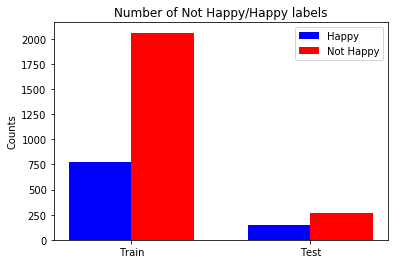

In [139]:
print(x.shape)
print(y.shape)
print(x_ev.shape)
print(y_ev.shape)

LabelVis.plot_happy_bars(y,y_ev)


In [140]:
#Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state = 1)
results_rbf = pd.DataFrame(columns=('C','Gamma','Avg PR'))#,'AUC ROC'))
cs = np.random.uniform(0,5,100)
gammas = 2**(np.random.choice(18,100)-15.)

for idx,(g,c) in enumerate(zip(gammas,cs)):
    classifier = svm.SVC(C=c,kernel='rbf', probability = True,gamma = g, random_state=5)
    auc_pr = util.get_auc_score(classifier, cv, x, y, go_after_pr=True)
    #auc_roc =util.get_auc_score(classifier, cv, x, y, go_after_pr=False)
    results_rbf.loc[idx] = [c,g,auc_pr]
    print('Gamma = %.6f, C= %2.2f, Avg PR: %.4f' % (g,c,auc_pr))
    

Gamma = 0.000488, C= 2.10, Avg PR: 0.7973
Gamma = 0.250000, C= 3.31, Avg PR: 0.9232
Gamma = 0.000122, C= 3.70, Avg PR: 0.6665
Gamma = 0.003906, C= 0.34, Avg PR: 0.9220
Gamma = 0.007812, C= 0.99, Avg PR: 0.9760
Gamma = 0.250000, C= 2.02, Avg PR: 0.9232
Gamma = 0.000977, C= 3.71, Avg PR: 0.9312
Gamma = 0.250000, C= 3.79, Avg PR: 0.9232
Gamma = 4.000000, C= 2.42, Avg PR: 0.2385
Gamma = 0.003906, C= 4.73, Avg PR: 0.9774
Gamma = 0.007812, C= 2.21, Avg PR: 0.9803
Gamma = 0.000244, C= 3.31, Avg PR: 0.7363
Gamma = 0.000977, C= 2.43, Avg PR: 0.9065
Gamma = 0.001953, C= 3.87, Avg PR: 0.9647
Gamma = 0.250000, C= 1.23, Avg PR: 0.9245
Gamma = 0.000122, C= 3.81, Avg PR: 0.6680
Gamma = 1.000000, C= 4.96, Avg PR: 0.3005
Gamma = 0.000122, C= 1.56, Avg PR: 0.6339
Gamma = 0.125000, C= 1.20, Avg PR: 0.9482
Gamma = 0.031250, C= 0.61, Avg PR: 0.9775
Gamma = 0.062500, C= 3.09, Avg PR: 0.9691
Gamma = 0.000977, C= 0.43, Avg PR: 0.7693
Gamma = 0.000977, C= 3.61, Avg PR: 0.9297
Gamma = 0.000061, C= 0.35, Avg PR:

In [127]:
dutil.save_results(results_rbf,configs, '_rbf')

In [128]:
best_choice = util.get_best_hyperparas_results(results_rbf, col='Avg PR') #what were the best hyperparas?
print(best_choice)
best_c,best_g =best_choice[:2]


C         1.623250
Gamma     0.015625
Avg PR    0.847443
Name: 13, dtype: float64


0.9694795423475407
1.0 1.0 1.0
0.0 0.0 0.0


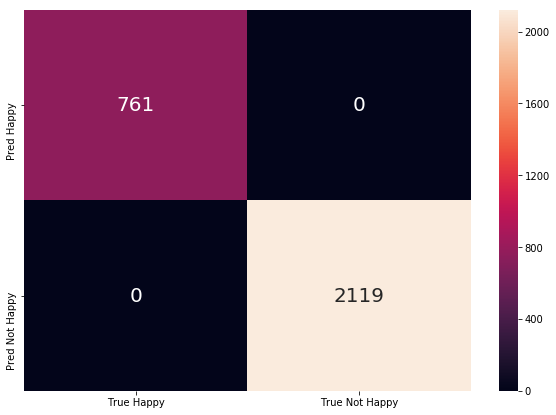

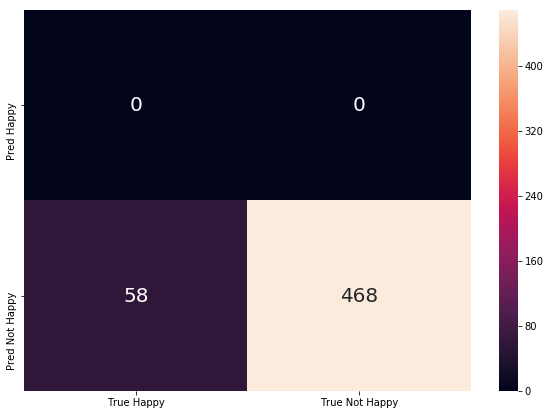

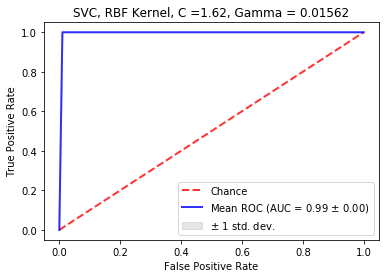

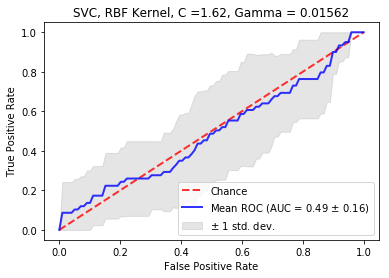

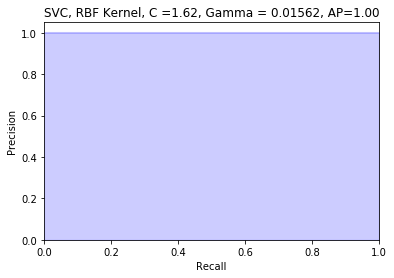

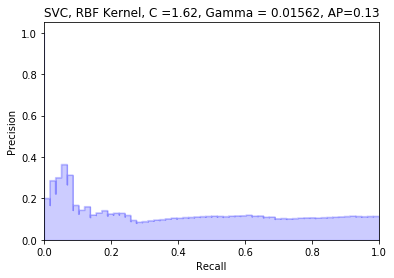

In [129]:
###using hyperpara found, evaluate and get pretty plots

classifier = svm.SVC(C=best_c, kernel='rbf', probability=True,gamma = best_g,random_state=5)
best_thr = util.get_optimal_threshold(classifier, cv, x, y, go_after_pr=True) # get threshold using cv
#for thr in np.linspace(0,1,10):
print(best_thr)
y_pred,y_pred_ev = util.fit_predict(classifier, best_thr, x, y, x_ev, y_ev) # using that threshold, get predictions and f1 score
f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
f1_ev=get_f1(y_pred_ev,y_ev)
prec_tr,recall_tr = get_precision_recall(y_pred,y)
prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)

print(prec_tr, recall_tr,f1_tr)
print(prec_ev, recall_ev,f1_ev)


ClassificationVis.conf_mat(y_pred,y)
ClassificationVis.conf_mat(y_pred_ev,y_ev)
plt.show()
classifier.fit(x,y)
ClassificationVis.plot_roc(x,y,classifier, 'SVC, RBF Kernel, C ={:.2f}, Gamma = {:.5f}'.format(best_c,best_g))
ClassificationVis.plot_roc(x_ev,y_ev,classifier, 'SVC, RBF Kernel, C ={:.2f}, Gamma = {:.5f}'.format(best_c,best_g))
ClassificationVis.plot_pr_curve(x,y,classifier,'SVC, RBF Kernel, C ={:.2f}, Gamma = {:.5f}'.format(best_c,best_g))
ClassificationVis.plot_pr_curve(x_ev,y_ev,classifier,'SVC, RBF Kernel, C ={:.2f}, Gamma = {:.5f}'.format(best_c,best_g))

In [143]:
x.shape

(2839, 89)

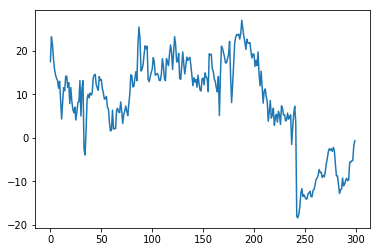

In [144]:
plt.plot(x[1300:1600,0])